# Recurrent Neural Networks From Scratch

Source: This notebook was taken from UCLAIS Tutorials Season 2.

### 1.1 RNN as a sequential model

The neural networks in previous tutorials are **feedforward neural networks**, which take one input (e.g. information about one credit card transaction) and transform it onto one output (e.g. fraudulent or not). Here, the model processes each instance independently. 

In sequential data however, instances of data are not independent. Sequential data is data where order matters, including text streams, audio clips, video clips, time series like stock prices. Predicting the next value in the sequence often requires information about many past values in the sequence, not just the latest value.

<br>
<div id="intro_images">
    <div style="display:inline-block;">
    <img src="https://miro.medium.com/max/626/0*SaNg8uUaKCMQSS5g.jpg" width="300"/>
    </div>
    <div style="display:inline-block;">
    <img src="https://iq.opengenus.org/content/images/2019/12/1_XvUt5wDQA8D3C0wAuxAvbA.png" width="500"/>
    </div>
</div>

**Recurrent neural networks** are a type of neural networks suitable for sequential data. Unike feedforward neural networks, RNN keeps a memory of past inputs. The newest input (latest time step in the sequence) is combined with this memory to generate an output that continues the sequence. 

(E.g. to predict the closing price of a stock tomorrow, the RNN takes today's closing price, as well as memory of closing prices in the past n number of days.)


In [57]:
!pip install --upgrade pandas_datareader

import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

In [59]:
# Use pandas datareader to obtain stock data from Yahoo Finance
data = web.DataReader('AAPL', 'yahoo', start='2021-01-01', end='2021-11-23')

data.head()

High         Low  ...       Volume   Adj Close
Date                                ...                         
2021-01-04  133.610001  126.760002  ...  143301900.0  128.617096
2021-01-05  131.740005  128.429993  ...   97664900.0  130.207306
2021-01-06  131.050003  126.379997  ...  155088000.0  125.824318
2021-01-07  131.630005  127.860001  ...  109578200.0  130.117844
2021-01-08  132.630005  130.229996  ...  105158200.0  131.240921

[5 rows x 6 columns]

Date
2021-01-04    129.410004
2021-01-05    131.009995
2021-01-06    126.599998
2021-01-07    130.919998
2021-01-08    132.050003
                 ...    
2021-11-16    151.000000
2021-11-17    153.490005
2021-11-18    157.869995
2021-11-19    160.550003
2021-11-22    161.020004
Name: Close, Length: 225, dtype: float64


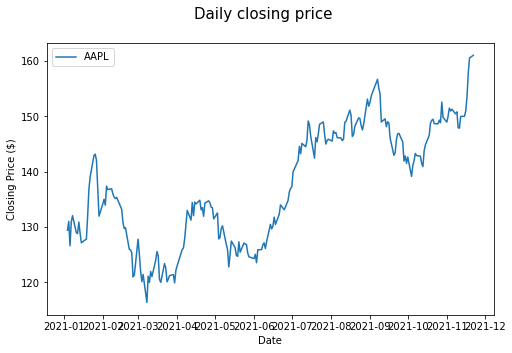

In [60]:
# visualizing the daily closing price
close=data['Close'] 

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(close.index,close,label="AAPL")
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price ($)")
fig.suptitle('Daily closing price', fontsize=15)
ax.legend()
print(close)

### 1.2 RNN structure and layers

<div style="display:inline-block;">
<img src="https://i.imgur.com/4Mdtx7Y.jpeg" width="550"/>
</div>

#### How is a recurrent neuron different from the usual neuron?

1. **The recurrent neuron as a hidden state / cell state** ($h_t$): the internal memory of the recurrent neuron. It is initialized as a zero matrix, and updated after each time step to include the information inputted at that time step.

2. **The recurrent neuron's output is a function of input and memory ($y_t = f(X_t,  h_{t-1})$), instead of just a function of input($y_t = f(X_t)$)**
<br>
<br>


#### Two layers of an RNN:    
1. **Recurrent layer**: updating the hidden state

$h_t = f(h_{t-1} \times W_{hh} + X_t \times W_xh + B_1)$

$h_t$: hidden state at time step $t$. $h_0$ is initialized as a matrix of zeros. 
$W_{hh}$: weight matrix determining how the previous hidden state affects the current hidden state
$W_{xh}$: weight matrix determining how the current input ($X$) affects the current hidden state
$B_1$: bias of the recurrent layer
$f()$: activation function of the recurrent layer
<br>
<br>

2. **Feedforward layer**: using the updated hidden state to produce an output

$\hat{y}_t = g(h_t \times W_{hy} + B_2)$

$\hat{y}_t$: output at time step $t$
$W_{hy}$: weight matrix determining how current hidden state affects output
$B_1$: bias of the feedforward layer
$g()$: activation function of the feedforward layer

Note: once trained, the same weight matrices will be used across all time steps.
<br>
<br>

#### Activation functions
Just like neural networks in previous tutorials, RNNs need activation functions to introduce non-linearity and enable learning of more complex patterns. 

Common activation functions for RNN:
- sigmoid
- ReLU
- tanh 

### 1.3 Back propagation through time
- Step 1: Values of an input sequence are passed through the model in order. At each time step, the model generates an output and calculates its loss.
    
    $$L_t = f_l(\hat{y}, y)$$
    
    $L_t$: loss of the output at time $t$

    $f_l$: loss function
    
    $\hat{y}$: prediction output

    $y$: actual label
<br>

- Step 2: The losses of all the time steps are summed into a total loss for the input sequence. 

    $$L = \sum_{t} L_t $$
    
    $L$: total loss
<br>

- Step 3: Error is propagated back through each time step by taking the derivative of total loss with respect to each trainable parameter
    
    $$\frac{\partial L}{\partial \theta} = \sum_{t} \frac{\partial L_t}{\partial \theta}
    $$
    
    Where $\theta$ is any trainable parameter. 
    <br>
    The equation above represents the derivative of the total loss as a sum of the derivatives of losses at each time step. These time step losses are each calculated with:
    \begin{equation}
    \frac{\partial L_t}{\partial \theta} = \sum_{k=1}^{t} \frac{\partial L_t}{\partial y_t} \frac{\partial y_t}{\partial h_t}  \frac{\partial h_t}{\partial h_k} \frac{\partial h_k}{\partial \theta}
    \end{equation}
    
    <br>
    Thus, the derivative of the total loss is:

    \begin{equation}
    \frac{\partial L}{\partial \theta} = \sum_{t} \sum_{k=1}^{t} \frac{\partial L_t}{\partial y_t} \frac{\partial y_t}{\partial h_t}  \frac{\partial h_t}{\partial h_k} \frac{\partial h_k}{\partial \theta}
    \end{equation}
    
    <br>
    This derivative w.r.t each weight is multiplied by a learning rate to adjust the weights, and learning is achieved.

### 1.4 RNN implementation from scratch



So far, we have defined the structure of simple recurrent neural network; however, how does this translate into code?

In the following section, we will have a look into implementation from scratch for the prediction of simple sine function.

For starters, let's create a sample dataset by dividing the sine function into sequences of 50 units. For the model itself, we will try to predict the next value for the sequence.

In [61]:
import math
import numpy as np
import matplotlib.pyplot as plt

#Preparing our dataset
sine =  np.array([math.sin(x) for x in np.arange(200)])

#Creating our train dataset
X = []
Y = []

#Defining the lenght of our sequence and number of samples
seq_len = 50
num_records = len(sine) - seq_len

for i in range(num_records - 50):
    X.append(sine[i:i+seq_len])
    Y.append(sine[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

To later test our model's performance, let's also create a validation dataset (we will use to after the training).

In [62]:
#Creating our validation dataset
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sine[i:i+seq_len])
    Y_val.append(sine[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

Now, let's start defining our simple RNN model. As it has been mentioned earlier, our model will produce a single output after processing input through a hidden state of 100 units.

In the following cell, we also need to initialize the starting weights of our network:
- U - weights between the input and hidden layers
- V - weights between the hidden and output layers
- W - weights for shared weights in the RNN hidden layer

In [63]:
#Creating RNN
learning_rate = 0.0001    
num_epoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

#Initializing weights
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

Finally, let's also define our activation function used in the hidden layer (sigmoid):

In [64]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#### Training our model

As it has been mentioned in the previous sections, the training of RNN model can be divided into the following steps:
- Calculating loss on train dataset
- Forward pass
- Backward pass
- Updating weights

In [ ]:
for epoch in range(num_epoch):
    # defining loss
    loss = 0.0
    
    # generating initial prediction
    for i in range(Y.shape[0]):
        
        #Retrieving input and output for sequence
        x, y = X[i], Y[i]
        
        #Initializing value of previous hidden layer
        prev_s = np.zeros((hidden_dim, 1))   
        for t in range(T):
            
            #Forward pass for every sequence
            new_input = np.zeros(x.shape)    
            new_input[t] = x[t]
            
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            
            #Passing through activation function
            s = sigmoid(add)
            mulv = np.dot(V, s)
            
            #Defining previous state
            prev_s = s

        #Calculating error
        loss_per_seq = (y - mulv)**2 / 2
        loss += loss_per_seq
        
    loss = loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss)
    
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # Forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            
            #Multiplying the input witht the weights
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            
            #Adding to capture information from the previous timestep
            add = mulw + mulu
            
            #Passing through activation function
            s = sigmoid(add)
            mulv = np.dot(V, s)
            
            #Saving current and previous states
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
        dmulv = (mulv - y)
        
        # Backpropagation
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            
            # Ensuring that the gradients' values fall within our predefined range
            # between min_clip_value and max_clip_value
            
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # Updating our weights
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Finally, after training, we can test our model with previously defined validation dataset.

In [66]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))

    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'b')
plt.plot(Y_val[:, 0], 'r')
plt.show()

### 1.5 RNN implementation in Tensorflow

In [67]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
#check missing value
data.isna().sum()

In [69]:
#scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close.values.reshape(-1,1))
scaled_data.shape

(225, 1)

In [70]:
#define functions to split data
def input_output_split(dataset, y_start, y_end, history):
  X = []
  y = []
  y_start += history
  for i in range(y_start, y_end):
    indices = range(i-history, i)
    X.append(np.reshape(dataset[indices], (history, 1)))
    y.append(dataset[i])
  return np.array(X), np.array(y)

def test_train_split(dataset, train_ratio, history):
  training_size = int(dataset.size * train_ratio)
  X_train, y_train = input_output_split(dataset, 0, training_size, history)
  X_test, y_test = input_output_split(dataset, training_size, len(dataset), history)
  return X_train, y_train, X_test, y_test


RNN expects input dataset to be 3D-shaped (instances, timesteps, features)


In [85]:
#split data
X_train, y_train, X_test, y_test = test_train_split(scaled_data, 0.8, 10)

X_train.shape, y_train.shape

((170, 10, 1), (170, 1))

In [ ]:
#create model
def create_RNN(hidden_units, dense_units, input_shape, activation):
    rmodel = Sequential()

    # recurrent layer:
    rmodel.add(SimpleRNN(hidden_units, input_shape=input_shape, 
                        activation=activation[0]))
    # feedfoward layer:
    rmodel.add(Dense(units=dense_units, activation=activation[1]))

    rmodel.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])

    return rmodel
 
RNN_model = create_RNN(8, 1, (10,1), activation=['sigmoid', 'relu'])

RNN_model.summary()

In [ ]:
#train model
RNN_model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

In [90]:
#predict using test set
y_pred = RNN_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % (mse))

y_pred = scaler.inverse_transform(y_pred).flatten()
print(y_pred)

MSE: 0.003
[139.70413 140.73264 141.66429 142.77484 142.67307 142.56572 141.56274
 140.91917 142.99507 144.19817 145.64993 147.53839 148.21982 148.4688
 147.93082 147.79124 148.27608 148.01979 150.64854 149.14284 148.19508
 148.84677 150.03354 149.84937 150.02527 149.4628  149.62015 147.55537
 147.13347 148.65814 148.9387  149.67935 151.59358 154.94313 157.27788]


In [91]:
#visualize the predictions
y_pred = np.concatenate(([None]*(len(data)-len(y_pred)),y_pred))
result = pd.DataFrame({'predicted':y_pred, 'target':close}, index=data.index)
result.plot().set_ylabel("AAPL Closing Price ($)")

Text(0, 0.5, 'AAPL Closing Price ($)')

Reference:

https://www.ibm.com/cloud/learn/recurrent-neural-networks

http://introtodeeplearning.com/slides/6S191_MIT_DeepLearning_L2.pdf

https://www.youtube.com/watch?v=qjrad0V0uJE

https://towardsdatascience.com/sequence-models-and-recurrent-neural-networks-rnns-62cadeb4f1e1

https://towardsdatascience.com/under-the-hood-of-neural-networks-part-2-recurrent-af091247ba78

https://medium.com/deep-math-machine-learning-ai/chapter-10-deepnlp-recurrent-neural-networks-with-math-c4a6846a50a2

https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

https://www.youtube.com/watch?v=p5pDBGoJmR0